# "Folio 03: MLP Classifier"
> "[ML 3/3] Use Neural Networks for Data Classification with Keras"

- toc: true
- branch: master
- badges: true
- image: images/ipynb/mlp_clf_main.png
- comments: false
- author: Giaco Stantino
- categories: [portfolio project, machine learning]
- hide: false
- search_exclude: true
- permalink: /blog/folio-mlp-classifier

# Intro

I would like to try something new. I want to build something more *explainatory* and *exploraroty*... to use my experience and knowledge gained while working on computer vision for my master's thesis. 

I think this the perfect oportunity! In the third part of ML notebooks for Folio series we are going to **build MLP classifier** that is very focused on explaining accuracy improving and regularization techniques. In this notebook I try to explain some core neural network features and training with Keras library. 

***

**Task:** Classify existing clients into marketing segments based on bank statistics.


The notebook consists of:
1. Data Transformation
2. Activation Function
3. Number of layers
4. Number of epoches
5. Regularization

***

In [2]:
#collapse-hide
import pandas as pd
import numpy as np
import tensorflow as tf

# # # set random seeds
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
# # #

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
#collapse-hide
def getDataRepo(data='demographics'):
    """
    returns specified data from Repository as DataFrame
    Parameters:
    path - ['demographics', 'statistics' or 'segments']; default: 'demographics'
    """
    try:
        url = 'https://github.com/giastantino/PortfolioProject/blob/main/Notebooks/Data/' + data + '.csv?raw=True'
        client_df = pd.read_csv(url)
        print(data + ' data has been read')
        return client_df
    except Exception as e:
        print(e)

In [4]:
#collapse-hide
# read demographic data
demo_df = getDataRepo('statistics')

# read segments data
segment_df = getDataRepo('segments')

# create df for clients with known segment
client_df = demo_df.merge(segment_df, on='client_id')

# create df for clients with unknown segment
unknown_df = demo_df[~demo_df['client_id'].isin(segment_df['client_id'])].reset_index(drop=True)

statistics data has been read
segments data has been read


# Data transformation

We are going to use power transform like in clustering notebook. 

Let's check if anything is missing in imported data.

In [5]:
#collapse-hide
print(f"NaN values in the data:\n-----------------\n{client_df.isna().sum()}")

NaN values in the data:
-----------------
client_id                                0
attrition_flag                           0
months_on_book                           0
products_num_held_by_client              0
inactive_months_in_last_year             0
contacts_in_last_year                    0
average_open_to_buy_credit_line          0
total_transaction_amount_change_q4_q1    0
total_transaction_amount_last_year       0
total_transaction_count_last_year        0
total_trasaction_count_change_q4_q1      0
average_card_utilazation_ratio           0
segment                                  0
dtype: int64


In [6]:
#hide
print(client_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8223 entries, 0 to 8222
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   client_id                              8223 non-null   int64  
 1   attrition_flag                         8223 non-null   object 
 2   months_on_book                         8223 non-null   int64  
 3   products_num_held_by_client            8223 non-null   int64  
 4   inactive_months_in_last_year           8223 non-null   int64  
 5   contacts_in_last_year                  8223 non-null   int64  
 6   average_open_to_buy_credit_line        8223 non-null   float64
 7   total_transaction_amount_change_q4_q1  8223 non-null   float64
 8   total_transaction_amount_last_year     8223 non-null   float64
 9   total_transaction_count_last_year      8223 non-null   int64  
 10  total_trasaction_count_change_q4_q1    8223 non-null   int64  
 11  aver

***

Define data X and targets y for our neural network.

In [7]:
from sklearn.model_selection import train_test_split

# define target y and data X
X = client_df.drop(['client_id','segment', 'attrition_flag'],axis=1).values
y = client_df[['segment']]

Transform the data and encode the targets. We need to one-hot encode the target classes as neural network will return 'probability' for each class in separate neurons. 

In [8]:
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from keras.utils import np_utils

# encode data X
ptr = PowerTransformer()
X = ptr.fit_transform(X)

# encode target y
encoder = LabelEncoder()
encoded_y = encoder.fit_transform(np.ravel(y))
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_y)

Split the data into training and testing dataset.

In [9]:
from sklearn.model_selection import train_test_split

# define the 80_20 train_test splits 
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.2, random_state=42)

# <center> Baseline model </center>

In this notebook we are using Multilayer Perceptron as our classifier. Let's define the base model with 10 neurons in the hidden layer.

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# define number of input features
input_features = X_train.shape[1]

# uncompiled model
def uncompiled_base(input_dim=4):
	# create model
  model = Sequential()
  model.add(Dense(10, input_dim=input_dim, activation='linear'))
  model.add(Dense(4, activation='softmax'))
	
  return model

# baseline model
def baseline_model(input_dim):
  model = uncompiled_base(input_dim=input_dim)
  
  # Compile model
  model.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

  return model

# define model
mlp = baseline_model(input_dim=input_features)

# checkup model
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 4)                 44        
                                                                 
Total params: 154
Trainable params: 154
Non-trainable params: 0
_________________________________________________________________


In [11]:
# train baseline model
history = mlp.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0)
print(f'BASELINE\taccuracy: {history.history["accuracy"][-1]*100:.2f} \t validation accuracy: {history.history["val_accuracy"][-1]*100:.2f}')

BASELINE	accuracy: 96.64 	 validation accuracy: 97.11


The baseline model with linear neuron scores around 97% in training. Let's try to best it with modifications.

# <center> Activation Function </center>

The activation function is performed on the sum of all inputs, for the classic perceptron it was a unipolar function, which output was a binary function. However, in modern neural networks, and thus MLP as well, a different approach is commonly used, such as the ReLU or Sigmoid function. 

<center><img src="https://github.com/giastantino/repository/blob/main/images/ipynb/mlp_clf_neuron.png?raw=true" width="400"></center>

***

Let's consider three activation functions and how they affect our model: [sigmoid](#), [ReLU](#) and [softplus](#)

<center><img src="https://github.com/giastantino/repository/blob/main/images/ipynb/mlp_clf_activationfunction.png?raw=true" width="500"></center>

Sigmoid function squishes any real number into a range between 0 and 1, mathematically 1 / (1 + np.exp(-x)). ReLU is a function that for negative  input returns 0 and for postive returns itself. SoftPlus is a smooth approximation to the ReLU function.


> Note: In the model we are using softmax fuction in the final layer to make multiclass predictions.

In [12]:
def get_active_model(input_dim=4, act_fun='relu'):
	# create model
  model = Sequential()
  model.add(Dense(10, input_dim=input_dim, activation=act_fun))
  model.add(Dense(4, activation='softmax'))
	
  # compile model
  model.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])
  return model

# define mlp with relu activation
sigm_mlp = get_active_model(input_dim=input_features, act_fun='sigmoid')
# define mlp with relu activation
relu_mlp = get_active_model(input_dim=input_features, act_fun='relu')
# define mlp with relu activation
soft_mlp = get_active_model(input_dim=input_features, act_fun='softmax')

In [61]:
#collapse-hide
# train sigmoid model
sigm_story = sigm_mlp.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0)
print(f'Sigmoid model \taccuracy: {sigm_story.history["accuracy"][-1]*100:.2f} \t validation accuracy: {sigm_story.history["val_accuracy"][-1]*100:.2f}')

# train relu model
relu_story = relu_mlp.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0)
print(f'ReLU model    \taccuracy: {relu_story.history["accuracy"][-1]*100:.2f} \t validation accuracy: {relu_story.history["val_accuracy"][-1]*100:.2f}')

# train softmax model
soft_story = soft_mlp.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0)
print(f'Softmax model \taccuracy: {soft_story.history["accuracy"][-1]*100:.2f} \t validation accuracy: {soft_story.history["val_accuracy"][-1]*100:.2f}')

Sigmoid model 	accuracy: 95.97 	 validation accuracy: 95.44
ReLU model    	accuracy: 97.21 	 validation accuracy: 97.19
Softmax model 	accuracy: 96.45 	 validation accuracy: 96.20


In our case model with ReLU activation function outperform other MLPs. It has 0.0.6% better accuracy than the baseline model with linear function, which is 17% error reduction! Let's use the ReLU function for further experiments.

> Warning: Sometimes sigmoid or softmax function may outperform ReLu based models when changing the architecture, eg. adding extra layers. Therefore it is important to conduct experiments in methodical fashion.

# <center> Number of layers and neurons </center>

MLP stands for multi layer perceptron, but so far we were using model with input, hidden and  output layer. Let's try adding hidden layers and increasing number of neurons.

In [13]:
def get_model(input_dim=4, hidden_layers=[], act_fun='relu'):
	# create model
  model = Sequential()
  # add initial layer
  model.add(Dense(hidden_layers[0], input_dim=input_dim, activation=act_fun))
  # add hidden layers
  for layer in hidden_layers[1:]:
    model.add(Dense(layer, activation=act_fun))
  # add final layer
  model.add(Dense(4, activation='softmax'))
	# compile model
  model.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])
  return model

In [14]:
# defince hidden layers to inspect
hidden = dict()
hidden[0] = [10]
hidden[1] = [50]
hidden[2] = [10, 10]
hidden[3] = [50, 50]
hidden[4] = [100, 100]
hidden[5] = [10, 10, 10]
hidden[6] = [20, 20, 20]
hidden[7] = [50, 50, 50]
hidden[8] = [100, 100, 100]
hidden[9] = [100, 50, 100]

# get accuracies for models with hidden layers
for hid in hidden:
  model = get_model(input_dim=input_features, hidden_layers=hidden[hid])
  story = model.fit(X_train, y_train, epochs=20, batch_size=50, validation_split=0.2, verbose=0)
  print(f'hidden layers: {hidden[hid]}  \taccuracy: {story.history["accuracy"][-1]*100:.2f} \t validation accuracy: {story.history["val_accuracy"][-1]*100:.2f}')

hidden layers: [10]  	accuracy: 96.37 	 validation accuracy: 96.05
hidden layers: [50]  	accuracy: 98.19 	 validation accuracy: 97.64
hidden layers: [10, 10]  	accuracy: 96.88 	 validation accuracy: 96.20
hidden layers: [50, 50]  	accuracy: 99.14 	 validation accuracy: 97.80
hidden layers: [100, 100]  	accuracy: 99.28 	 validation accuracy: 97.87
hidden layers: [10, 10, 10]  	accuracy: 97.74 	 validation accuracy: 96.43
hidden layers: [20, 20, 20]  	accuracy: 98.29 	 validation accuracy: 96.88
hidden layers: [50, 50, 50]  	accuracy: 99.24 	 validation accuracy: 97.42
hidden layers: [100, 100, 100]  	accuracy: 99.43 	 validation accuracy: 97.34
hidden layers: [100, 50, 100]  	accuracy: 99.22 	 validation accuracy: 97.64


We can see that increasing number of layers and neurons has a positvie impact on training accuracy, however it is not that obviuos for validation subset. We can see that models bigger than `[50, 50]` hidden layers do better in training but not in validation - this suggests that bigger models are overfitting. In other words, bigger models are capable of learning traning data by heart, which is not desirable for test data.

Let's inspect further the best performing model: `[input, 50, 50, output]`

# <center> Epoches and Batches </center>

We can increase model's performance with more training epoches - number of times MLP has seen traning data. Moreover, we can also manipulate number of objects model sees each iteration in the epoch - batches.

## Batch Size

Let's inspect validation accuracy of chosen model with diffrent batch sizes: online training (batch_size=1), 10, 20, 50, 100.

In [118]:
# batch sizes
batches = [1, 10, 20, 50, 100]
# model results history dictionary
history = dict()
# define model
mlp = get_model(input_dim=input_features, hidden_layers=[50,50])
# iterate through batch sizes
for b in batches:
  story = mlp.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=b, verbose=0)
  history[b] = story.history['val_accuracy']

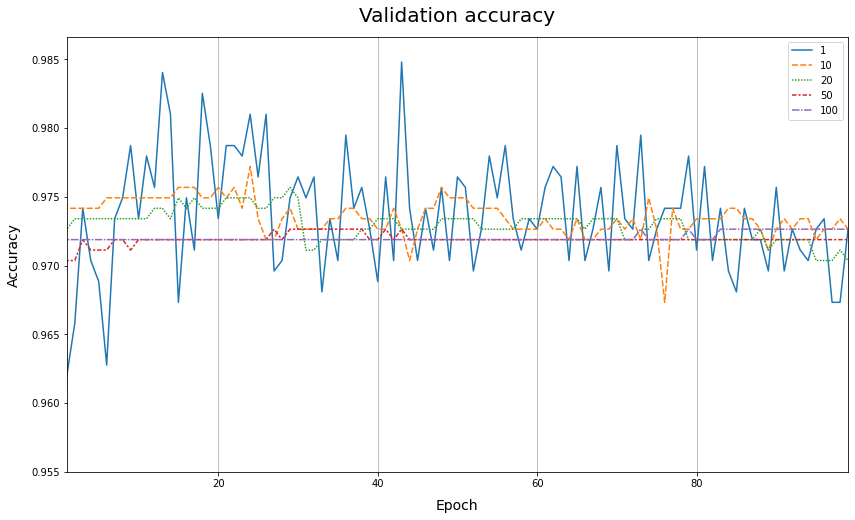

In [119]:
#collapse-hide
# plot validation accuracies
fig, ax = plt.subplots(figsize=(14, 8))
line = sns.lineplot(data = pd.DataFrame(history))

# setup the plot
line.xaxis.grid(True)
line.set_xlabel('Epoch', fontsize=14, labelpad = 10)
line.set_ylabel('Accuracy', fontsize=14, labelpad = 10)
line.set_title('Validation accuracy', fontsize=20, pad=15)
line.set_xlim(1, 99)
line.set_ylim(0.955, None);

In the above figure we can clearly see that accuracy score for `batch_size = 1` is very irregular and thus not predictible. On the other hand, for large batch sizes score is stable, which suggest that network doesn't learn new features with consequent epochs. Therefore we are going to proceed with `batch_size = 10`, which looks like good middle ground in our case.


## Overfitting vs number of epoches

Having chosen the architecture and batch size. we shall check how our model behaves in terms of loss (cost function). How many epoches improve model predictions and if the overfitting occurs.

In [16]:
# fit the model
model = get_model(input_dim=input_features, hidden_layers=[50,50],)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=150, batch_size=10, verbose=0)

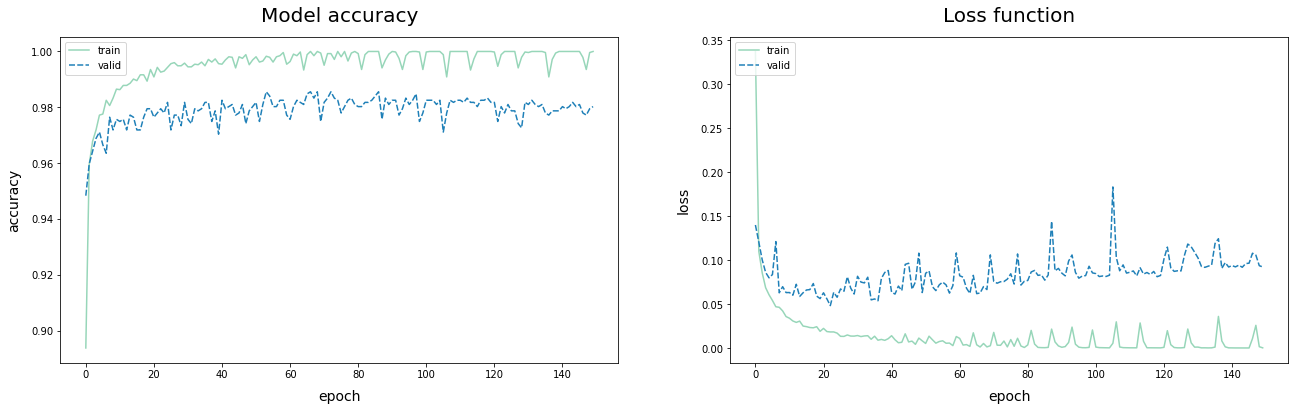

In [17]:
#collapse-hide
# define dataframe with model metrics
df = pd.DataFrame(history.history, columns=history.history.keys())

# setup figure
fig, (ax1, ax2) = plt.subplots(figsize=(22, 6), ncols=2)

# plot model accuracy 
fig1 = sns.lineplot(data=df[['accuracy','val_accuracy']], palette='YlGnBu', ax=ax1)
fig1.set_title('Model accuracy', fontsize=20, pad=15)
fig1.set_ylabel('accuracy', fontsize=14, labelpad = 10)
fig1.set_xlabel('epoch', fontsize=14, labelpad = 10)
fig1.legend(['train', 'valid'], loc='upper left')

# plot model loss function
fig2 = sns.lineplot(data=df[['loss','val_loss']], palette='YlGnBu', ax=ax2)
fig2.set_title('Loss function', fontsize=20, pad=15)
fig2.set_ylabel('loss', fontsize=14, labelpad = 10)
fig2.set_xlabel('epoch', fontsize=14, labelpad = 10)
fig2.legend(['train', 'valid'], loc='upper left');

In the above graphs, there are plotted model scores for accuracy on the left and for the value of loss function on the rigth. We can see that model doesn't improve in term's of accuracy after ca. 60 epochs. On the other hand it starts to overfit the data after ca. 40 epochs - the loss function for training and validation spreads out in different directions.

In order to prevent model from overfitting we will use some regularization techniques.


# Regularization

Having read this notebook we could relize how complex neural networks are. This makes them more prone to overfitting. Regularization is a technique which makes slight modifications to the learning algorithm such that the model generalizes better. This in turn improves the model's performance on the unseen data as well.

## Dropout

This is one of the most interesting types of regularization techniques. It also produces very good results and is consequently the most frequently used regularization technique in the field of deep learning.

So what does dropout do? At every iteration, it randomly selects some nodes and removes them along with all of their incoming and outgoing connections as shown below.

<center><img src="https://github.com/giastantino/repository/blob/main/images/ipynb/mlp_clf_dropout.png?raw=true" width="400"></center>


## Early stopping

Early stopping is a kind of cross-validation strategy where we keep one part of the training set as the validation set. When we see that the performance on the validation set is getting worse, we immediately stop the training on the model. This is known as early stopping.

<center><img src="https://github.com/giastantino/repository/blob/main/images/ipynb/mlp_clf_earlystopping.png.png?raw=true"></center>

# <center> Summary </center>

Let's sum up everythin in final code cell. Firstly, we define the `get_model` function with hidden layer and drop rate. Then, we create callback objects which represent early stopping and saving the checkpoint model - currently the best model based on test accuracy.

In [134]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tqdm.keras import TqdmCallback

# get model
def get_model(input_dim=4, layers=[], drop_rate=0.2, act_fun='relu'):
	# create model
  model = Sequential()
  # add initial layer with dropout
  model.add(Dense(layers[0], input_dim=input_dim, activation=act_fun))
  model.add(Dropout(drop_rate))
  # add hidden layers
  for layer in layers[1:]:
    model.add(Dense(layer, activation=act_fun))
    model.add(Dropout(drop_rate))
  # add final layer  
  model.add(Dense(4, activation='softmax'))
	# compile the model
  model.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])
  return model

# early stopping
es = EarlyStopping(monitor="val_loss",
                   patience=20, # how long to wait for loss to decrease
                   verbose=0,
                   mode="min",
                   restore_best_weights=False,
                   )
# model checkpoints
mc = ModelCheckpoint('best_model.h5',
                     monitor='val_accuracy',
                     mode='max',
                     verbose=0,  # set 1 to see when model is saved
                     save_best_only=True
                     )
# define model
model = get_model(input_dim=input_features, layers=[50,50], drop_rate=0.2)
# fit model
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=150, 
                    verbose=0, 
                    callbacks=[es, mc, TqdmCallback(verbose=1)],
                    )
# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('\nTrain: %.3f, Test: %.3f' % (train_acc, test_acc))



0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Train: 0.996, Test: 0.990


We can see that the early stopping strategy worked and stoped training. The best model for run epoches, and thus our final model, has the highest accuracy of all neutwork we experimented with before. 

Let's plot confusion matrix of the predictions made by the final MLP.

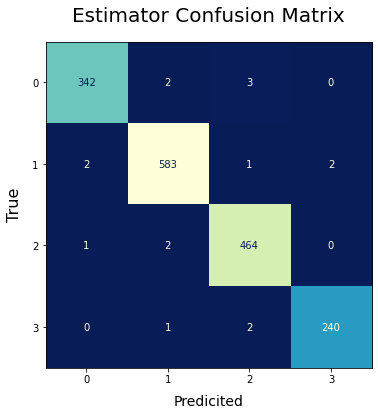

In [148]:
#collapse-hide
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = saved_model.predict(X_test)
y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)

fig, ax = plt.subplots(figsize=(6, 6))

ConfusionMatrixDisplay.from_predictions(y_test_class, y_pred_class, cmap='YlGnBu_r', colorbar = False, ax = ax)
ax.set_title('Estimator Confusion Matrix', fontsize=20, pad=20)
ax.set_xlabel('Predicited', fontsize = 14, labelpad=10)
ax.set_ylabel('True', fontsize = 16, labelpad=10);

Our neural network has not only high accuracy, but also precision of predictions is very high, as show in the confusion matrix above.

# Final thoughts

The goal was to create the MLP classifier. To complete the task we used Keras. We created the model that does very well in training data and thanks to regularization techniques it generalizes and predicts with hich precision and accuracy on unseen data. 